In [1]:
import numpy as np
from numba import jit, njit
import matplotlib.pyplot as plt
from random import randint
from sklearn.datasets import make_blobs
from utility import *
from tqdm import tqdm
from sklearn.cluster import k_means

# Local search

Implementazione dell'algoritmo di local search per la soluzione del problema di clustering.

L'algoritmo parte da una soluzione generata casualmente e la migliora iterativamente selezionando, dall'intorno di questa, la miglior soluzione adiacente disponibile.

L'intorno di una mossa è calcolato applicando due tipologie di mosse:
* spostamento di un nodo da un cluster ad un altro
* scambio di due nodi

Per motivi di efficienza l'algoritmo opera su un sottoinsieme campionato in maniera casuale degli elementi dell'intorno della soluzione analizzata.

La funzione neighbors_clustering restituisce un sottoinsieme dell'intorno della soluzione calcolato mediante le mosse precedentemente discusse.

La funzione local_search realizza invece l'algoritmo di ricerca locale utilizzando come metrica la funzione di squared_inner_distance definita in utiliy.py

In [2]:
@njit
def neighbors_clustering(sol, points, K):
    neighbors = []

    q = int(len(points)/50) + 1

    choices = np.arange(len(sol))
    orig_val = squared_inner_distance(sol, points, K)
    centroids = calc_centroids(sol, points, K)

    for i in range(q):
        choice = np.random.randint(len(choices))
        choices = np.delete(choices, choice)
        for k in range(K):
            new_sol = sol.copy()
            if(k != new_sol[choice]):
                new_sol[choice] = k
                new_val = orig_val - np.linalg.norm(points[choice]-centroids[sol[choice]])**2 + np.linalg.norm(points[choice]-centroids[k])**2
                neighbors.append((new_sol,new_val))


    choices1 = np.arange(len(sol))
    choices2 = np.arange(len(sol))
    for i in range(q):
        choice1 = np.random.randint(len(choices1))
        choices1 = np.delete(choices1, choice1)
        choice2 = np.random.randint(len(choices2))
        choices2 = np.delete(choices2, choice2)

        new_sol = sol.copy()
        new_sol[choice1], new_sol[choice2] = new_sol[choice2], new_sol[choice1]

        new_val = orig_val - np.linalg.norm(points[choice1]-centroids[sol[choice1]])**2 - np.linalg.norm(points[choice2]-centroids[sol[choice2]])**2 + np.linalg.norm(points[choice1]-centroids[sol[choice2]])**2 + np.linalg.norm(points[choice2]-centroids[sol[choice1]])**2
        neighbors.append((new_sol,new_val))
        
    return neighbors

In [3]:
@njit
def local_search(base_sol, points, K, verbose = True):
    old_sol = base_sol
    base_val = squared_inner_distance(old_sol, points, K)
    iter = 0
    same_sol = 0

    while True:
        neighbourhood = neighbors_clustering(old_sol, points, K)
        best_val = squared_inner_distance(old_sol, points , K)
        best_sol = old_sol

        if verbose and iter%50 == 0:
            print("Iteration number:", iter, "Valore percentuale:", best_val/base_val*100, "%")

        for sol,val in neighbourhood:
            if(val < best_val):
                best_val = val
                best_sol = sol
        
        if((best_sol == old_sol).all()):
            same_sol = same_sol + 1
            if(same_sol == 500):
                break
        else:
            same_sol = 0
            old_sol = best_sol

        iter = iter+1
    return old_sol

# Esempio di utilizzo della local search

Testiamo l'euristica dell'euristica con un istanza di 1000 punti di $R^2$ e un numero di cluster pari K pari a 10.

L'insieme di punti su cui è testata l'euristica è generato tramite la funzione make_blobs che genera un insieme di punti di $R^n$ con specifici parametri regolabili.

Iteration number: 0 Valore percentuale: 100.0 %
Iteration number: 50 Valore percentuale: 90.37217738839124 %
Iteration number: 100 Valore percentuale: 76.27927375577848 %
Iteration number: 150 Valore percentuale: 65.69930413709535 %
Iteration number: 200 Valore percentuale: 56.36285160482316 %
Iteration number: 250 Valore percentuale: 48.85733295202296 %
Iteration number: 300 Valore percentuale: 40.91075844116403 %
Iteration number: 350 Valore percentuale: 33.90371093074472 %
Iteration number: 400 Valore percentuale: 28.293093973465062 %
Iteration number: 450 Valore percentuale: 24.094127594526146 %
Iteration number: 500 Valore percentuale: 20.459003575992128 %
Iteration number: 550 Valore percentuale: 17.667394563237426 %
Iteration number: 600 Valore percentuale: 15.41312458049669 %
Iteration number: 650 Valore percentuale: 13.160881024044391 %
Iteration number: 700 Valore percentuale: 11.383937983521225 %
Iteration number: 750 Valore percentuale: 9.60350616217793 %
Iteration number: 

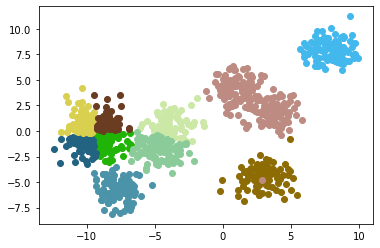

In [4]:
K = 10
N = 1000

points, centroids = make_blobs(n_samples=N, centers=K, n_features=2, random_state=np.random.randint(10))

sol = np.random.randint(K, size = N)
sol = local_search(sol, points, K)

print("Il valore di f.obj ottenuta è: {:.5E}".format(squared_inner_distance(sol, points, K)))

printR2sol(points, sol, K)